In [1]:
# default_exp circuit

# Circuit

> SAX Circuits

Let's start where we left off (see [Netlist](06_netlist.ipynb)).

In [2]:
# export
from __future__ import annotations

import os
import shutil
import sys
from functools import partial
from pprint import pprint
from typing import Any, Dict, List, NamedTuple, Optional, Tuple, TypedDict, Union

import black
import networkx as nx
import numpy as np
from pydantic import ValidationError
from sax import reciprocal
from sax.backends import circuit_backends
from sax.multimode import multimode, singlemode
from sax.netlist import Netlist, RecursiveNetlist, load_recursive_netlist
from sax.netlist_cleaning import remove_unused_instances
from sax.typing_ import Model, Settings, SType
from sax.utils import _replace_kwargs, get_settings, merge_dicts, update_settings

Let's start by creating a simple recursive netlist with gdsfactory.

:::{note}
We are using gdsfactory to create our netlist because it allows us to see the circuit we want to simulate and because we're striving to have a compatible netlist implementation in SAX.

However... gdsfactory is not a dependency of SAX. You can also define your circuits by hand (see [SAX Quick Start](../examples/01_quick_start.ipynb) or you can use another tool to programmatically construct your netlists.
:::

2023-01-05 17:06:06.012 | INFO     | gdsfactory.config:<module>:48 - Load '/home/bilodeaus/miniconda3/envs/sax/lib/python3.10/site-packages/gdsfactory' 6.18.3


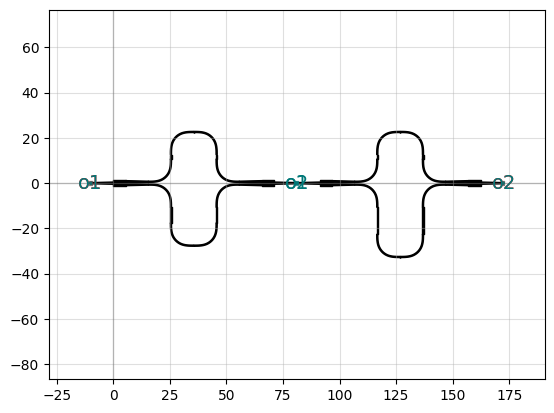

twomzi: uid 3738831b, ports ['o1', 'o2'], references ['mzi_1', 'mzi_2'], 0 polygons

In [3]:
import gdsfactory as gf
from IPython.display import display
from gdsfactory.components import mzi
from gdsfactory.get_netlist import get_netlist_recursive, get_netlist, get_netlist_yaml

@gf.cell
def twomzi():
    c = gf.Component()
    
    # instances
    mzi1 = mzi(delta_length=10)
    mzi2 = mzi(delta_length=20)
    
    # references
    mzi1_ = (c << mzi1)
    mzi2_ = (c << mzi2)
    
    # connections
    mzi2_.connect('o1', mzi1_.ports['o2'])
    
    # ports
    c.add_port('o1', port=mzi1_.ports['o1'])
    c.add_port('o2', port=mzi2_.ports['o2'])
    return c

comp  = twomzi()
display(comp)
recnet = RecursiveNetlist.parse_obj(get_netlist_recursive(comp, get_netlist_func=partial(get_netlist, full_settings=True)))
flatnet = recnet.__root__['mzi_delta_length10']

To be able to model this device we'll need some SAX dummy models:

In [4]:
# hide
def bend_euler(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return reciprocal({
        ('o1', 'o2'): 1.0
    })

In [5]:
# hide
def mmi1x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return reciprocal({
        ('o1', 'o2'): 0.45**0.5,
        ('o1', 'o3'): 0.45**0.5,
    })

In [6]:
# hide
def mmi2x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return reciprocal({
        ('o1', 'o3'): 0.45**0.5,
        ('o1', 'o4'): 1j * 0.45**0.5,
        ('o2', 'o3'): 1j * 0.45**0.5,
        ('o2', 'o4'): 0.45**0.5,
    })

In [7]:
# hide
def straight(
    length=0.01,
    #npoints=2,
    #with_bbox=True,
    #cross_section=...
):
    return reciprocal({
        ('o1', 'o2'): 1.0
    })

In SAX, we usually aggregate the available models in a models dictionary:

In [8]:
models = {
    'straight': straight,
    'bend_euler': bend_euler,
    'mmi1x2': mmi1x2,
}

We can now represent our recursive netlist model as a Directed Acyclic Graph:

In [9]:
# export
def create_dag(
    netlist: RecursiveNetlist,
    models: Optional[Dict[str, Any]] = None,
):
    if models is None:
        models = {}
    assert isinstance(models, dict)
    
    all_models = {}
    g = nx.DiGraph()

    for model_name, subnetlist in netlist.dict()['__root__'].items():
        if not model_name in all_models:
            all_models[model_name] = models.get(model_name, subnetlist)
            g.add_node(model_name)
        if model_name in models:
            continue
        for instance in subnetlist['instances'].values():
            component = instance['component']
            if not component in all_models:
                all_models[component] = models.get(component, None)
                g.add_node(component)
            g.add_edge(model_name, component)
    
    # we only need the nodes that depend on the parent...
    parent_node = next(iter(netlist.__root__.keys()))
    nodes = [parent_node, *nx.descendants(g, parent_node)]
    g = nx.induced_subgraph(g, nodes)
            
    return g

In [10]:
# export

def draw_dag(dag, with_labels=True, **kwargs):
    _patch_path()
    if shutil.which('dot'):
        return nx.draw(dag, nx.nx_pydot.pydot_layout(dag, prog='dot'), with_labels=with_labels, **kwargs)
    else:
        return nx.draw(dag, _my_dag_pos(dag), with_labels=with_labels, **kwargs)
    
def _patch_path():
    os_paths = {p: None for p in os.environ.get('PATH', '').split(os.pathsep)}
    sys_paths = {p: None for p in sys.path}
    other_paths = {os.path.dirname(sys.executable): None}
    os.environ['PATH'] = os.pathsep.join({**os_paths, **sys_paths, **other_paths})

def _my_dag_pos(dag):
    # inferior to pydot
    in_degree = {}
    for k, v in dag.in_degree():
        if v not in in_degree:
            in_degree[v] = []
        in_degree[v].append(k)

    widths = {k: len(vs) for k, vs in in_degree.items()}
    width = max(widths.values())
    height = max(widths) + 1
    
    horizontal_pos = {k: np.linspace(0, 1, w+2)[1:-1]*width for k, w in widths.items()}

    pos = {}
    for k, vs in in_degree.items():
        for x, v in zip(horizontal_pos[k], vs):
            pos[v] = (x, -k)
    return pos

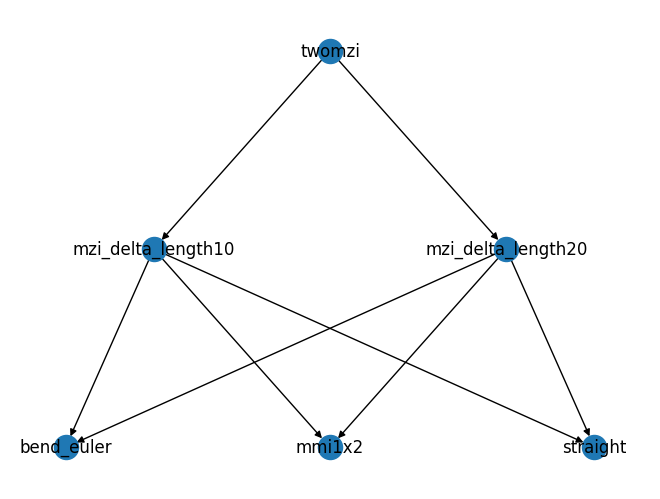

In [11]:
dag = create_dag(recnet, models)
draw_dag(dag)

Note that the DAG depends on the models we supply. We could for example stub one of the sub-netlists by a pre-defined model:

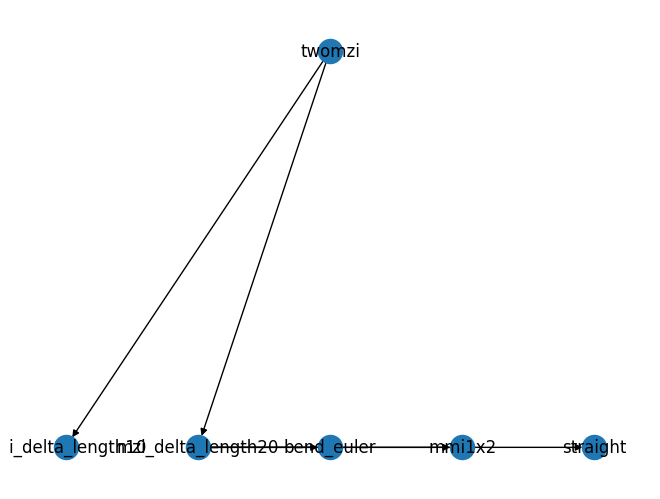

In [12]:
dag_ = create_dag(recnet, {**models, 'mzi_delta_length10': mmi2x2})
draw_dag(dag_, with_labels=True)

This is useful if we for example pre-calculated a certain model.

We can easily find the root of the DAG:

In [13]:
# export
def find_root(g):
    nodes = [n for n, d in g.in_degree() if d == 0]
    return nodes

In [14]:
find_root(dag)

['twomzi']

Similarly we can find the leaves:

In [15]:
# export
def find_leaves(g):
    nodes = [n for n, d in g.out_degree() if d == 0]
    return nodes

In [16]:
find_leaves(dag)

['bend_euler', 'mmi1x2', 'straight']

To be able to simulate the circuit, we need to supply a model for each of the leaves in the dependency DAG. Let's write a validator that checks this

In [17]:
# export
def _validate_models(models, dag):
    required_models = find_leaves(dag)
    missing_models = [m for m in required_models if m not in models]
    if missing_models:
        model_diff = {
            "Missing Models": missing_models,
            "Given Models": list(models),
            "Required Models": required_models,
        }
        raise ValueError(
            "Missing models. The following models are still missing to build the circuit:\n"
            f"{black.format_str(repr(model_diff), mode=black.Mode())}"
        )
    return {**models} # shallow copy

In [18]:
models = _validate_models(models, dag)

We can now dow a bottom-up simulation. Since at the bottom of the DAG, our circuit is always flat (i.e. not hierarchical) we can implement a minimal `_flat_circuit` definition, which only needs to work on a flat (non-hierarchical circuit):

In [19]:
# export
def _flat_circuit(instances, connections, ports, models, backend):
    evaluate_circuit = circuit_backends[backend]

    inst2model = {k: models[inst.component] for k, inst in instances.items()}

    model_settings = {name: get_settings(model) for name, model in inst2model.items()}
    print(model_settings)
    netlist_settings = {
        name: {k: v for k, v in (inst.settings or {}).items() if k in model_settings[name]}
        for name, inst in instances.items()
    }
    default_settings = merge_dicts(model_settings, netlist_settings)

    def _circuit(**settings: Settings) -> SType:
        settings = merge_dicts(default_settings, settings)
        settings = _forward_global_settings(inst2model, settings)

        instances: Dict[str, SType] = {}
        for inst_name, model in inst2model.items():
            instances[inst_name] = model(**settings.get(inst_name, {}))
        #print(f"{instances=}")
        #print(f"{connections=}")
        #print(f"{ports=}")
        S = evaluate_circuit(instances, connections, ports)
        return S

    _replace_kwargs(_circuit, **default_settings)

    return _circuit

def _forward_global_settings(instances, settings):
    global_settings = {}
    for k in list(settings.keys()):
        if k in instances:
            continue
        global_settings[k] = settings.pop(k)
    if global_settings:
        settings = update_settings(settings, **global_settings)
    return settings

In [20]:
flatnet = recnet.__root__['mzi_delta_length10']
single_mzi = _flat_circuit(flatnet.instances, flatnet.connections, flatnet.ports, models, "default")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'bend_euler_1': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_2': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_3': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_4': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_5': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_6': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_7': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'bend_euler_8': {'angle': Array(90., dtype=float32), 'p': Array(0.5, dtype=float32)}, 'cp1': {'width': Array(0.5, dtype=float32), 'width_taper': Array(1., dtype=float32), 'length_taper': Array(10., dtype=float32), 'length_mmi': Array(5.5, dtype=float32), 'width_mmi': Array(2.5, dtype=float32), 'gap_mmi': Array(0.25, dtype=float32)}, 'cp2': {'width': Array(0.5, dtype=float32), 'width_taper': Arr

The resulting circuit is just another SAX model (i.e. a python function) returing an SType:

In [21]:
single_mzi?

Signature:
single_mzi(
    *,
    bend_euler_1={'angle': 90.0, 'p': 0.5},
    bend_euler_2={'angle': 90.0, 'p': 0.5},
    bend_euler_3={'angle': 90.0, 'p': 0.5},
    bend_euler_4={'angle': 90.0, 'p': 0.5},
    bend_euler_5={'angle': 90.0, 'p': 0.5},
    bend_euler_6={'angle': 90.0, 'p': 0.5},
    bend_euler_7={'angle': 90.0, 'p': 0.5},
    bend_euler_8={'angle': 90.0, 'p': 0.5},
    cp1={'width': None, 'width_taper': 1.0, 'length_taper': 10.0, 'length_mmi': 5.5, 'width_mmi': 2.5, 'gap_mmi': 0.25},
    cp2={'width': None, 'width_taper': 1.0, 'length_taper': 10.0, 'length_mmi': 5.5, 'width_mmi': 2.5, 'gap_mmi': 0.25},
    straight_10={'length': 0.01},
    straight_5={'length': 0.09},
    straight_6={'length': 2.0},
    straight_7={'length': 0.01},
    straight_8={'length': 0.09},
    straight_9={'length': 7.0},
    sxb={'length': 0.1},
    sxt={'length': 0.1},
    syl={'length': 7.0},
    sytl={'length': 2.0},
) -> 'SType'
Docstring: <no docstring>
File:      /tmp/ipykernel_2632617/15553

Let's 'execute' the circuit:

In [22]:
single_mzi()

{('o1', 'o1'): Array(0., dtype=float32, weak_type=True),
 ('o2', 'o2'): Array(0., dtype=float32, weak_type=True),
 ('o1', 'o2'): Array(0.90000004, dtype=float32, weak_type=True),
 ('o2', 'o1'): Array(0.90000004, dtype=float32, weak_type=True)}

Now that we can handle flat circuits the extension to hierarchical circuits is not so difficult:

In [25]:
# export

def circuit(
    netlist: Union[Netlist, NetlistDict, RecursiveNetlist, RecursiveNetlistDict],
    models: Optional[Dict[str, Model]] = None,
    connection_models: Optional[Dict[Tuple(str,str), Model]] = None,
    modes: Optional[List[str]] = None,
    backend: str = "default",
) -> Tuple[Model, CircuitInfo]:
    netlist = _ensure_recursive_netlist_dict(netlist)
    
    # TODO: do the following two steps *after* recursive netlist parsing.
    netlist = remove_unused_instances(netlist)
    netlist, instance_models = _extract_instance_models(netlist)
    
    recnet: RecursiveNetlist = _validate_net(netlist)

    # add connection models into recursive netlist
    if connection_models:
        recnet, models = _add_connection_models_recursive(recnet, models, connection_models)
    
    dependency_dag: nx.DiGraph = _validate_dag(create_dag(recnet, models))  # directed acyclic graph
    models = _validate_models({**(models or {}), **instance_models}, dependency_dag)
    modes = _validate_modes(modes)
    backend = _validate_circuit_backend(backend)

    circuit = None
    new_models = {}
    current_models = {}
    model_names = list(nx.topological_sort(dependency_dag))[::-1]
    for model_name in model_names:
        if model_name in models:
            new_models[model_name] = models[model_name]
            continue

        flatnet = recnet.__root__[model_name]

        connections, ports, new_models = _make_singlemode_or_multimode(
            flatnet, modes, new_models
        )
        current_models.update(new_models)
        new_models = {}

        current_models[model_name] = circuit = _flat_circuit(
            flatnet.instances, connections, ports, current_models, backend
        )

    assert circuit is not None
    return circuit, CircuitInfo(dag=dependency_dag, models=current_models)

class NetlistDict(TypedDict):
    instances: Dict
    connections: Dict[str, str]
    ports: Dict[str, str]
    
RecursiveNetlistDict = Dict[str, NetlistDict]

class CircuitInfo(NamedTuple):
    dag: nx.DiGraph
    models: Dict[str, Model]

def _ensure_recursive_netlist_dict(netlist):
    if not isinstance(netlist, dict):
        netlist = netlist.dict()
    if '__root__' in netlist:
        netlist = netlist['__root__']
    if 'instances' in netlist:
        netlist = {'top_level': netlist}
    netlist = {**netlist}
    for k, v in netlist.items():
        netlist[k] = {**v}
    return netlist

def _extract_instance_models(netlist):
    models = {}
    for netname, net in netlist.items():
        net = {**net}
        net['instances'] = {**net['instances']}
        for name, inst in net['instances'].items():
            if callable(inst):
                settings = get_settings(inst)
                if isinstance(inst, partial) and inst.args:
                    raise ValueError("SAX circuits and netlists don't support partials with positional arguments.")
                while isinstance(inst, partial):
                    inst = inst.func
                models[inst.__name__] = inst
                net['instances'][name] = {
                    'component': inst.__name__,
                    'settings': settings
                }
        netlist[netname] = net
    return netlist, models


def _validate_circuit_backend(backend):
    backend = backend.lower()
    # assert valid circuit_backend
    if backend not in circuit_backends:
        raise KeyError(
            f"circuit backend {backend} not found. Allowed circuit backends: "
            f"{', '.join(circuit_backends.keys())}."
        )
    return backend


def _validate_modes(modes) -> List[str]:
    if modes is None:
        return ["te"]
    elif not modes:
        return ["te"]
    elif isinstance(modes, str):
        return [modes]
    elif all(isinstance(m, str) for m in modes):
        return modes
    else:
        raise ValueError(f"Invalid modes given: {modes}")


def _validate_net(netlist: Union[Netlist, RecursiveNetlist]) -> RecursiveNetlist:
    if isinstance(netlist, dict):
        try:
            netlist = Netlist.parse_obj(netlist)
        except ValidationError:
            netlist = RecursiveNetlist.parse_obj(netlist)
    elif isinstance(netlist, Netlist):
        netlist = RecursiveNetlist(__root__={"top_level": netlist})
    return netlist


def _validate_dag(dag):
    nodes = find_root(dag)
    if len(nodes) > 1:
        raise ValueError(f"Multiple top_levels found in netlist: {nodes}")
    if len(nodes) < 1:
        raise ValueError(f"Netlist does not contain any nodes.")
    if not dag.is_directed():
        raise ValueError("Netlist dependency cycles detected!")
    return dag


def _make_singlemode_or_multimode(netlist, modes, models):
    if len(modes) == 1:
        connections, ports, models = _make_singlemode(netlist, modes[0], models)
    else:
        connections, ports, models = _make_multimode(netlist, modes, models)
    return connections, ports, models


def _make_singlemode(netlist, mode, models):
    models = {k: singlemode(m, mode=mode) for k, m in models.items()}
    return netlist.connections, netlist.ports, models


def _make_multimode(netlist, modes, models):
    models = {k: multimode(m, modes=modes) for k, m in models.items()}
    connections = {
        f"{p1}@{mode}": f"{p2}@{mode}"
        for p1, p2 in netlist.connections.items()
        for mode in modes
    }
    ports = {
        f"{p1}@{mode}": f"{p2}@{mode}"
        for p1, p2 in netlist.ports.items()
        for mode in modes
    }
    return connections, ports, models


def _add_connection_models_recursive(recnet, models, connection_models):
    for net, netlist in recnet.__root__.items():
        netlist, models = _add_connection_models(netlist, models, connection_models)
    return recnet, models

def _add_connection_models(netlist, models, connection_models):
    print(netlist.instances)
    for (ports1, ports2), connection_model in connection_models.items():
        found_connection = False
        if (ports1, ports2) in netlist.connections.items():
            del netlist.connections[ports1]
            port_in, port_out = ports1, ports2
            found_connection = True
        elif (ports2, ports1) in netlist.connections.items():
            del netlist.connections[ports2]
            port_in, port_out = ports2, ports1
            found_connection = True      
        if found_connection:
            netlist.connections[port_in] = port_out
            # Try adding a dict with "component" key
            # netlist.instances[f"{port_in}:{port_out}"] = {"component": f"{port_in}:{port_out}", "settings": {}}
            # Try adding a dummy component
            netlist.instances[f"{port_in}:{port_out}"] = gf.Component(name=f"{port_in}:{port_out}")
            models[f"{port_in}:{port_out}"] = connection_model
    return netlist, models

# def _validate_connection_models(recnet, connection_models):
#     for key, value in connection_models.items():
#         if key not in recnet["connections"]:
#             raise ValueError(f"Found connection model key {key} not in netlist connections.")

#     return connection_models

# Attempt with notebook 5 example

In [26]:
double_mzi, info = circuit(recnet, 
                            models, 
                            connection_models={("test1", "test2"): straight, 
                                                ('bend_euler_1,o1', 'cp1,o3'): straight
                            })
double_mzi()

{'mzi_1': Component(
    component="mzi_delta_length10",
    settings={
        "delta_length": 10,
        "length_y": 2.0,
        "length_x": 0.1,
        "bend": {"function": "bend_euler"},
        "straight": {"function": "straight"},
        "straight_y": None,
        "straight_x_top": None,
        "straight_x_bot": None,
        "splitter": "mmi1x2",
        "combiner": None,
        "with_splitter": True,
        "port_e1_splitter": "o2",
        "port_e0_splitter": "o3",
        "port_e1_combiner": "o2",
        "port_e0_combiner": "o3",
        "nbends": 2,
        "cross_section": "strip",
        "cross_section_x_top": None,
        "cross_section_x_bot": None,
    },
)
, 'mzi_2': Component(
    component="mzi_delta_length20",
    settings={
        "delta_length": 20,
        "length_y": 2.0,
        "length_x": 0.1,
        "bend": {"function": "bend_euler"},
        "straight": {"function": "straight"},
        "straight_y": None,
        "straight_x_top": None,
      

ValueError: 'component' not in []

# Attempt with Quick_Start example

In [ ]:
import sax
import jax.numpy as jnp

def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling ** 0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict

def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict

mzi, info = circuit(
    netlist={
        "instances": {
            "lft": "coupler",
            "top": "waveguide",
            "btm": "waveguide",
            "rgt": "coupler",
        },
        "connections": {
            "lft,out0": "btm,in0",
            "btm,out0": "rgt,in0",
            "lft,out1": "top,in0",
            "top,out0": "rgt,in1",
        },
        "ports": {
            "in0": "lft,in0",
            "in1": "lft,in1",
            "out0": "rgt,out0",
            "out1": "rgt,out1",
        },
    },
    models={
        "coupler": coupler,
        "waveguide": waveguide,
    },
    connection_models={("test1", "test2"): straight, 
                        ("lft,out0", "btm,in0"): straight
                            }
)

{'lft': Component(component="coupler", settings={})
, 'top': Component(component="waveguide", settings={})
, 'btm': Component(component="waveguide", settings={})
, 'rgt': Component(component="coupler", settings={})
}


TypeError: string indices must be integers

In [ ]:
mzi()

{('in0', 'in0'): Array(0.+0.j, dtype=complex64),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex64),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex64),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex64),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex64),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex64),
 ('out1', 'in0'): Array(-0.57127243+0.8207605j, dtype=complex64),
 ('out1', 'in1'): Array(0.+0.j, dtype=complex64),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex64),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex64),
 ('out0', 'in0'): Array(0.+0.j, dtype=complex64),
 ('out0', 'in1'): Array(-0.57127243+0.8207605j, dtype=complex64),
 ('in0', 'out1'): Array(-0.57127243+0.8207605j, dtype=complex64),
 ('in0', 'out0'): Array(0.+0.j, dtype=complex64),
 ('in1', 'out1'): Array(0.+0.j, dtype=complex64),
 ('in1', 'out0'): Array(-0.57127243+0.8207605j, dtype=complex64)}